In [1]:
import os
from collections import defaultdict
from itertools import chain
from collections import Counter
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Embedding,LSTM, Dense, Dropout, Input, Concatenate, TimeDistributed, Layer, Bidirectional, Flatten
from tensorflow.keras import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MultiLabelBinarizer
import numpy as np
import tensorflow.keras.backend as K
import matplotlib.pyplot as plt
import random
import operator
from tqdm import tqdm
from gensim.models import Word2Vec
from focal_loss import BinaryFocalLoss
from tensorflow.keras.models import load_model
import gensim.downloader as api
from gensim.models import KeyedVectors as word2vec
from gensim.models import Word2Vec
from sklearn.preprocessing import StandardScaler
import re
from keras import Model
import pickle
import math
from tensorflow_addons.metrics import F1Score, HammingLoss
from transformers import AutoTokenizer, TFAutoModel
import shutil

/opt/homebrew/Caskroom/miniforge/base/envs/tf/lib/python3.9/site-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.7.0 and strictly below 2.10.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.10.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  warnings.warn(


In [2]:
random.seed(43)

In [3]:
tag_removed_list = ['2-sat', 'chinese remainder theorem','fft','schedules','meet-in-the-middle','ternary search','expression parsing','graph matchings']
tag_removed_list = []

tags = list()
Tags_set = dict()
problems = list()
with open('../_tags.txt','r') as file:
    content = file.readlines()
    for line in content:
        line = line.rstrip()
        problem = list(eval(line).items())[0][0]
        tags = list(eval(line).items())[0][1]
        tag_result = list()
        for tag in tags:
            if tag not in tag_removed_list: tag_result.append(tag)
        if (tag_result != []):
            problems.append(problem)
            Tags_set[problem] = tag_result
            line = list(tag)
            for tag in tag_result:
                if (tag not in tags): tags.append(tag)

In [4]:
num_tag = dict()
for problem in Tags_set:
    for tag in Tags_set[problem]:
        if tag in num_tag:
            num_tag[tag] +=1
        else: num_tag[tag] = 1
for tag in num_tag:
    print(tag,num_tag[tag])

brute force 857
greedy 1303
implementation 1748
constructive algorithms 799
dfs and similar 516
trees 440
sortings 532
dp 1145
expression parsing 27
math 1418
data structures 882
strings 426
binary search 532
graphs 621
shortest paths 151
geometry 255
two pointers 237
divide and conquer 138
interactive 76
bitmasks 248
probabilities 139
*special 100
games 104
combinatorics 320
dsu 186
number theory 380
matrices 77
fft 39
graph matchings 41
hashing 115
ternary search 30
string suffix structures 58
meet-in-the-middle 30
flows 79
schedules 5
chinese remainder theorem 9
2-sat 15


In [5]:
NUM_CLASSIFIERS = len(num_tag)
print(NUM_CLASSIFIERS)

37


In [6]:
#Tokenizer
code_rep = ['ast', 'cfg', 'pdg']
properties = ['source','path','value']

In [7]:
# Max number of words in each code.
MAX_CONTEXT = dict()
maxPath = [500,50,100,100,200,750]
rep = ['ast','cfg','cdg','ddg','pdg','attention']
for index in range(len(rep)):
    MAX_CONTEXT[rep[index]] = maxPath[index]
# Dimension of Embedding layer
EMBEDDING_PATH_DIM = 128
EMBEDDING_TOKEN_DIM = 128
BERT_DIM = 768
MAX_NB_WORDS = 500000

In [8]:
import sys
from subprocess import call
from pathlib import Path
def run_system_command(cmd: str,
                       shell: bool = False,
                       err_msg: str = None,
                       verbose: bool = True,
                       split: bool = True,
                       stdout=None,
                       stderr=None) -> int:
    if verbose:
        sys.stdout.write("System cmd: {}\n".format(cmd))
    if split:
        cmd = cmd.split()
    rc = call(cmd, shell=shell, stdout=stdout, stderr=stderr)
    if err_msg and rc:
        sys.stderr.write(err_msg)
        exit(rc)
    return rc
class Source_Loader():
    def __init__(self, dir):
        self.dir = dir
        self.compiler = 'g++'
        self.tokenizer = self._ensure_tokenizer_exists()
    def remove_non_ascii(self, code):
        if not code:
            return
        return ''.join([i if ord(i) < 128 else ' ' for i in code])
    
    def remove_apostrophe(self, code):
        result = ""
        for index, ch in enumerate(code):
            if ch == '\'':
                if code[index - 1].isdigit() and code[index + 1].isdigit():
                    continue
            result +=ch
        return result

    def remove_external_includes(self, code):
        exclude = []
        lines = []
        for line in code.split("\n"):
            skip = False
            for restricted in exclude:
                if restricted in line:
                    skip = True
                    break
            if skip:
                continue
            lines.append(line)
        return "\n".join(lines)

    def remove_unused_code(self, code):

        excluded = []

        res = []
        in_comment_block = False

        for line in code.split("\n"):

            line = line.strip()
            if len(line) == 0:
                continue

            if line.startswith("//"):
                if line.endswith("\\\\"):
                    in_comment_block = True
                continue
            elif in_comment_block and line.endswith("\\"):
                in_comment_block = True
                continue
            elif in_comment_block:
                in_comment_block = False
                continue

            for s in excluded:
                if line.startswith(s) and "*/" not in line:
                    break
            else:
                res.append(line)

        return "\n".join(res)
    def preprocess(self, code):
        pipeline = [
            self.remove_non_ascii,
            self.remove_apostrophe,
            self.remove_external_includes,
            self.remove_unused_code
        ]
        for func in pipeline:
            code = func(code)

        return code
    
    def _ensure_tokenizer_exists(self):

        tokenizer_dir  ="../tokenizer" +  "/src"

        tokenizer_exe = "tokenizer"

        tokenizer_path = tokenizer_dir + "/" + tokenizer_exe

        if not os.path.exists(tokenizer_path):
            current_path = Path.cwd()
            os.chdir(tokenizer_dir)
            run_system_command("{} *.cpp *.h -o {}".format(self.compiler, tokenizer_path))
            os.chdir(current_path)

        return tokenizer_path
    @staticmethod
    def dump_source(path: str, code: str):
        """ Write solution to file """
        with open(path, "w") as f:
            f.write(code)
    def split_source_tokens(self, code,source_path,tokens_path):

        self.dump_source(source_path, code)

        tokenizer_cmd = "{} -t c {}".format(self.tokenizer, source_path)
        with open(tokens_path, "w") as f:
            rc = run_system_command(tokenizer_cmd,
                                    stdout=f,
                                    stderr=f,
                                    verbose=False)
            if rc:
                raise Exception("Failure occured during tokenization!")

        with open(tokens_path, "r") as f:
            tokens = []
            for line in f:
                if "//" not in line and "/*" not in line:
                    tokens.append(line.strip())
                elif "EOF encountered" in line:
                    raise Exception("Failure occured during tokenizer!")
        return tokens
    def run(self, prob_name, code_name):
        #try:
            with open(self.dir + prob_name + '/' + code_name + '.cpp') as code_file:
                lines = code_file.readlines()
                code = []
                for index, line in enumerate(lines):
                    if len(line.strip()) > 0:
                        code.append(line.strip())
                code = '\n'.join(code)
            tokens = dict()
            code = self.preprocess(code)
            tokens = self.split_source_tokens(code, "./temp.cpp", "./solution.tokens")
            return tokens
        #except:
        #    raise Exception("Failed in file " + prob_name + " " + code_name)

In [9]:

class Dataset_Loader():
    def __init__(self,input_path, source_dir):
        self.input_path = input_path
        self.source_dir = source_dir
    def initial_code(self,problem_name, code_name):
        info = {}
        info['problem_name'] = problem_name
        info['code_name'] = code_name
        for code_rep in ['ast','cfg','pdg']:
            info[code_rep+'_source'] = list()
            info[code_rep+'_path'] = list()
            info[code_rep+'_value'] = list()
        info['tags'] = Tags_set[problem_name]
        return info
    def set_limit(self, content, path_name):
        if (len(content) > MAX_CONTEXT[path_name]):
            content = random.sample(content, MAX_CONTEXT[path_name])
        return content
    def get_info(self,code_info,content, path_name,problem_name):
        content = self.set_limit(content,path_name)
        for line in content:
            source, path, value = line.split(",")
            value = re.sub(r"\n","",value)
            if (path_name == 'ddg' or path_name == 'cdg'):
                code_info['pdg' + '_source'].append(source)
                code_info['pdg' + '_path'].append(path)
                code_info['pdg' + '_value'].append(value)
            else:
                code_info[path_name + '_source'].append(source)
                code_info[path_name + '_path'].append(path)
                code_info[path_name + '_value'].append(value)
    def load(self):
        dataset = []
        input_path = self.input_path
        for problem_name in tqdm(os.listdir(input_path)):
            if (problem_name != '.DS_Store' and problem_name in Tags_set.keys()):
                for code_name in os.listdir(input_path + problem_name):
                    if (code_name!= '.DS_Store'):

                        ### Get Path Info
                        code_info = self.initial_code(problem_name, code_name)
                        code_dir = os.path.join(input_path + problem_name, code_name)
                        for path_file in os.listdir(code_dir):
                            if (path_file.endswith(".txt")):
                                path_name = path_file.split(".")[0]
                                with open(os.path.join(code_dir, path_file), "r") as file:
                                    path_content = file.readlines()
                                    self.get_info(code_info, path_content, path_name,problem_name)
                        code_info['source'] = Source_Loader(self.source_dir).run(problem_name, code_name)
                        if (len(code_info['source']) > 745):
                            code_info['source'] = random.sample(code_info['source'],745)
                        dataset.append(code_info)
        return dataset


In [10]:
dataset_path = '../cpg_8_2/'
source_dir = '../preprocessing/dataset/'
Dataset = Dataset_Loader(input_path = dataset_path, source_dir = source_dir).load()

  1%|          | 33/5612 [00:01<05:01, 18.50it/s]


KeyboardInterrupt: 

In [686]:
with open("./dataset.pickle", "wb") as f:
    pickle.dump(Dataset,f)

In [11]:
with open('./dataset.pickle', "rb") as f:
    Dataset = pickle.load(f)

# Splitting Dataset

In [12]:
y = list()
for problem in problems:
    y.append(Tags_set[problem])

mlb = MultiLabelBinarizer()
y = mlb.fit_transform(y)

X = np.array(problems)

In [13]:
from iterstrat.ml_stratifiers import MultilabelStratifiedShuffleSplit

## Splitting dataset depends on problem
Percent = 80
msss = MultilabelStratifiedShuffleSplit(n_splits = 1, test_size = (1 - Percent / 100), random_state = 43)

for train_index, test_index in msss.split(X,y):
    train_problems, test_problems = X[train_index], X[test_index]

train_set = []
for item in Dataset:
    if item['problem_name'] in train_problems:
        train_set.append(item)
test_set = []
for item in Dataset:
    if item['problem_name'] in test_problems:
        test_set.append(item)
train_set = pd.DataFrame(data = train_set)
test_set = pd.DataFrame(data = test_set)
print(train_set.shape, test_set.shape)

(28644, 13) (7100, 13)


# Bert Tokenizer

In [ ]:
Berttokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
Bert_model = TFAutoModel.from_pretrained("bert-base-uncased")

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [ ]:
class Tokenize():
    def __init__(self, dataset, rep):
        self.dataset = dataset
        self.rep = rep
    def berttokenize(self,data):
        embedding = dict()
        embedding['token'] = list()
        embedding['attention_mask'] = list()
        data = data.to_list()
        for word in tqdm(data):
            word = ' '.join(word)
            bert = Berttokenizer(word, add_special_tokens = False, return_attention_mask=True, truncation = True, padding = 'max_length', max_length = MAX_CONTEXT[self.rep])
            embedding['token'].append(bert.data['input_ids']) #(len(data), MAX_CONTEXT)
            embedding['attention_mask'].append(bert.data['attention_mask']) #(len(data), MAX_CONTEXT)
        return np.append(np.empty(shape = (0,MAX_CONTEXT[rep])),embedding['token'], axis = 0), np.append(np.empty(shape = (0,MAX_CONTEXT[rep])),embedding['attention_mask'], axis = 0)
    def convert(self):
        token = dict()
        attention_mask = dict()
        mask = np.zeros(shape = ((len(self.dataset[self.rep + '_' + 'source']), MAX_CONTEXT[self.rep])))
        for property in properties:
            token[property], attention_mask[property]= self.berttokenize(self.dataset[self.rep + '_' + property])
            mask = np.logical_or(mask, attention_mask[property])
        return token['source'], token['path'], token['value'], mask

In [ ]:
x_train = dict()
attention_mask_train = dict()
x_test = dict()
attention_mask_test = dict()
for rep in code_rep:
    x_train[rep + '_source'], x_train[rep + '_path'], x_train[rep + '_value'], attention_mask_train[rep] = Tokenize(train_set, rep).convert()
    x_test[rep + '_source'], x_test[rep + '_path'], x_test[rep + '_value'], attention_mask_test[rep] = Tokenize(test_set, rep).convert()

100%|██████████| 3024/3024 [00:01<00:00, 1942.18it/s]


In [ ]:

with open('x_train.pickle','rb') as x_train_pickle:
    x_train = pickle.load(x_train_pickle)
with open('x_test.pickle','rb') as x_test_pickle:
    x_test = pickle.load(x_test_pickle)
with open('attention_mask_train.pickle','rb') as attention_mask_train_pickle:
    attention_mask_train = pickle.load(attention_mask_train_pickle)
with open('attention_mask_test.pickle','rb') as attention_mask_test_pickle:
    attention_mask_test = pickle.load(attention_mask_test_pickle)
with open('y_train.pickle','rb') as y_train_pickle:
    y_train = pickle.load(y_train_pickle)
with open('y_test.pickle','rb') as y_test_pickle:
    y_test = pickle.load(y_test_pickle)

# Tokenizer

In [14]:
tokenizer = dict()
x_train = dict()
x_test = dict()
for rep in code_rep:
    for property in properties:
        tokenizer[rep + '_' + property] = Tokenizer(num_words = MAX_NB_WORDS, lower = True, )
        tokenizer[rep + '_' + property].fit_on_texts(train_set[rep + '_' + property].values)
        x_train[rep + '_' + property] = tokenizer[rep + '_' + property].texts_to_sequences(train_set[rep + '_' + property].values)
        x_train[rep + '_' + property] = pad_sequences(x_train[rep + '_' + property], maxlen=MAX_CONTEXT[rep])
def tokenize_process(test_set,rep, property):
    x = tokenizer[rep + '_' + property].texts_to_sequences(test_set)
    x = pad_sequences(x, maxlen=MAX_CONTEXT[rep])
    return x
for rep in code_rep:
    for property in properties:
        x_test[rep + '_' + property] = tokenize_process(test_set[rep + '_' + property], rep, property)

In [15]:
#Source Code
tokenizer['source'] = Tokenizer(num_words = MAX_NB_WORDS, lower = True, filters='(),:;?@^_\t\n')
tokenizer['source'].fit_on_texts(train_set['source'].values)
x_train['source'] = tokenizer['source'].texts_to_sequences(train_set['source'].values)
x_test['source'] = tokenizer['source'].texts_to_sequences(test_set['source'].values)
x_train['source'] = pad_sequences(x_train['source'], maxlen = 745)
x_test['source'] = pad_sequences(x_test['source'], maxlen = 745)

# Create Context Valid Mask

In [16]:
context_valid_mask_train = dict()
context_valid_mask_test = dict()
for rep in code_rep:
    context_valid_mask_train[rep] = list()
    context_valid_mask_test[rep] = list()
    for property in properties:
        context_valid_mask_train[property] = list()
        context_valid_mask_test[property] = list()
        #Train set
        for value in x_train[rep + '_' + property]:
            context_valid_mask_train[property].append(np.asarray([1 if x > 0 else 0 for x in value]))
        context_valid_mask_train[rep].append(np.asarray(context_valid_mask_train[property]))
        #Test set
        for value in x_test[rep + '_' + property]:
            context_valid_mask_test[property].append(np.asarray([1 if x > 0 else 0 for x in value]))
        context_valid_mask_train[rep].append(np.asarray(context_valid_mask_test[property]))
    context_valid_mask_train[rep] = np.asarray(context_valid_mask_train[property])
    context_valid_mask_test[rep] = np.asarray(context_valid_mask_test[property])
#print(context_valid_mask_train['ast_source'])

In [17]:
mlb.fit(train_set['tags'])
y_train = mlb.transform(train_set['tags'])
y_test = mlb.transform(test_set['tags'])
print(y_train.shape, y_test.shape)

(28644, 37) (7100, 37)


In [695]:
with open('x_train.pickle', 'wb') as x_train_pickle:
    pickle.dump(x_train,x_train_pickle)
with open('x_test.pickle','wb') as x_test_pickle:
    pickle.dump(x_test,x_test_pickle)
with open('attention_mask_train.pickle',"wb") as attention_mask_train_pickle:
    pickle.dump(context_valid_mask_train, attention_mask_train_pickle)
with open('attention_mask_test.pickle',"wb") as attention_mask_test_pickle:
    pickle.dump(context_valid_mask_test, attention_mask_test_pickle)
with open('y_train.pickle', 'wb') as y_train_pickle:
    pickle.dump(y_train,y_train_pickle)
with open('y_test.pickle','wb') as y_test_pickle:
    pickle.dump(y_test,y_test_pickle)

In [ ]:
def isSparse(array) :
     
    counter = 0
  
    # Count number of zeros
    # in the matrix
    for i in range(len(array)) :
        if (array[i] == 0) :
            counter = counter + 1
  
    return (counter == len(array))

cnt = 0
for index in x_train['ast_source']:
    if (isSparse(index) == True):
        cnt+=1
print(cnt)

0


# Models

In [ ]:
w2v_model = word2vec.load_word2vec_format('../token_vecs.txt')

In [712]:
embed_matrix = dict()
for rep in code_rep:
    for property in ['source','value']:
        embed_matrix[rep + '_' + property] = np.zeros(shape = (MAX_CONTEXT[rep], EMBEDDING_TOKEN_DIM))
        for word, i in tokenizer[rep + '_' + property].word_index.items():
            try:
                embed_vector = w2v_model[word]
                if (embed_vector is not None):
                    embed_matrix[rep + '_' + property][i] = embed_vector
            except: pass
embed_matrix['source'] = np.zeros(shape = (745, EMBEDDING_TOKEN_DIM))
for word, i in tokenizer['source'].word_index.items():
    try:
        embed_vector = w2v_model[word]
        if (embed_vector is not None):
            embed_matrix['source'][i] = embed_vector
    except: pass

In [718]:
with open('w2v_embed_matrix.pickle','wb') as f:
    pickle.dump(embed_matrix, f)

In [18]:
w2v_inputs = [sample for sample in x_train['source']]
w2v_model = Word2Vec(w2v_inputs,
                vector_size = 100,
                window = 5,
                min_count =  3,
                workers = 32)
w2v_model.save('./')

TypeError: __init__() got an unexpected keyword argument 'size'

In [713]:
#Attention Layer
class AttentionLayer(Layer):
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, inputs_shape):
        inputs_shape = inputs_shape if isinstance(inputs_shape, list) else [inputs_shape]

        if len(inputs_shape) < 1 or len(inputs_shape) > 2:
            raise ValueError("AttentionLayer expect one or two inputs.")

        # The first (and required) input is the actual input to the layer
        input_shape = inputs_shape[0]

        # Expected input shape consists of a triplet: (batch, input_length, input_dim)
        if len(input_shape) != 3:
            raise ValueError("Input shape for AttentionLayer should be of 3 dimension.")

        self.input_length = int(input_shape[1])
        self.input_dim = int(input_shape[2])
        attention_param_shape = (self.input_dim, 1)

        self.attention_param = self.add_weight(
            name='attention_param',
            shape=attention_param_shape,
            initializer='uniform',
            trainable=True,
            dtype=tf.float32)
        super(AttentionLayer, self).build(input_shape)

    def call(self, inputs, **kwargs):
        inputs = inputs if isinstance(inputs, list) else [inputs]

        if len(inputs) < 1 or len(inputs) > 2:
            raise ValueError("AttentionLayer expect one or two inputs.")

        actual_input = inputs[0]
        mask = inputs[1] if len(inputs) > 1 else None
        if mask is not None and not (((len(mask.shape) == 3 and mask.shape[2] == 1) or len(mask.shape) == 2)
                                     and mask.shape[1] == self.input_length):
            raise ValueError("`mask` should be of shape (batch, input_length) or (batch, input_length, 1) "
                             "when calling an AttentionLayer.")

        assert actual_input.shape[-1] == self.attention_param.shape[0]

        # (batch, input_length, input_dim) * (input_dim, 1) ==> (batch, input_length, 1)
        attention_weights = K.dot(actual_input, self.attention_param)

        if mask is not None:
            if len(mask.shape) == 2:
                mask = K.expand_dims(mask, axis=2)  # (batch, input_length, 1)
            mask = K.log(mask)
            attention_weights += mask

        attention_weights = K.softmax(attention_weights, axis=1)  # (batch, input_length, 1)
        result = K.sum(actual_input * attention_weights, axis=1)  # (batch, input_length)  [multiplication uses broadcast]
        return result, attention_weights

    def compute_output_shape(self, input_shape):
        return input_shape[0], input_shape[2]  # (batch, input_dim)

In [698]:
def f1_score(y_true, y_pred):

    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.math.is_nan(f1), tf.zeros_like(f1), f1)
    return 1 - K.mean(f1)

In [721]:
input_nodes = {}

for rep in code_rep:

    #Input Layer
    source_input = Input(shape = (MAX_CONTEXT[rep],), dtype = tf.float64)
    path_input = Input(shape = (MAX_CONTEXT[rep],), dtype = tf.float64)
    value_input = Input(shape = (MAX_CONTEXT[rep],), dtype = tf.float64)
    
    attention_mask_input = Input(shape = (MAX_CONTEXT[rep],), dtype = tf.float64)

    #Bert Layer
    #_layer = Bert_model(source_input)[0]
    #bert_value_layer = Bert_model(value_input)[0]

    #Bert Dense
    #bert_source_dense = TimeDistributed(Dense(EMBEDDING_TOKEN_DIM,use_bias =False, activation = 'tanh'))(bert_source_layer)
    #bert_value_dense = TimeDistributed(Dense(EMBEDDING_TOKEN_DIM, use_bias = False, activation = 'tanh'))(bert_value_layer)

    #Embedding Path Input
    #path_embed = Embedding(MAX_SEQUENCE_LENGTH,EMBEDDING_PATH_DIM)(path_input)

    #Context Bert Layer
    #context_layer = Concatenate()([bert_source_dense, path_embed, bert_value_dense])
    #context_layer = Dropout(0.2)(context_layer)

    #Embedding Layer
    Embedding_source = Embedding(MAX_CONTEXT[rep], EMBEDDING_TOKEN_DIM, weights = [embed_matrix[rep + '_source']])(source_input)
    Embedding_path = Embedding(MAX_CONTEXT[rep],EMBEDDING_PATH_DIM)(path_input)
    Embedding_value = Embedding(MAX_CONTEXT[rep],EMBEDDING_TOKEN_DIM, weights = [embed_matrix[rep + '_value']])(value_input)
    
    #BiLSTM_token_layer = Bidirectional(LSTM(EMBEDDING_TOKEN_DIM,return_sequences=True))(Embedding_source)
    #BiLSTM_path_layer = Bidirectional(LSTM(EMBEDDING_PATH_DIM,return_sequences=True))(Embedding_path)
    #BiLSTM_value_layer = Bidirectional(LSTM(EMBEDDING_TOKEN_DIM,return_sequences=True))(Embedding_value)
 
    context_layer = Concatenate()([Embedding_source, Embedding_path, Embedding_value])
    context_layer = Dropout(0.2)(context_layer)

    #Context after Dense
    context_after_dense = TimeDistributed(Dense(2 * EMBEDDING_TOKEN_DIM + EMBEDDING_PATH_DIM, use_bias = False, activation = 'tanh'))(context_layer)

    #Attention Layer
    code_vector, _ = AttentionLayer()([context_after_dense,attention_mask_input])
    
    #code_vector = Dense(256, use_bias = False, activation = 'tanh')(code_vector)

    input_nodes[rep + '_source'] = source_input
    input_nodes[rep + '_path'] = path_input
    input_nodes[rep + '_value'] = value_input
    input_nodes[rep + '_code_vector'] = code_vector
    input_nodes[rep + '_attention_mask'] = attention_mask_input


source_code_input = Input(shape = (745,), dtype = tf.float64)
source_code_embed = Embedding(745, 128, weights = [embed_matrix['source']])(source_code_input)
source_code_LSTM = LSTM(128, return_sequences = True)(source_code_embed)
source_code_LSTM = Dropout(0.2)(source_code_LSTM)

source_code_vector, _ = AttentionLayer()([source_code_LSTM])

#Aggregating 3 code rep (AST, CFG, DPG):

code_vectors_layer = Concatenate()([input_nodes[rep + '_code_vector'] for rep in code_rep])
code_vectors_layer = Concatenate()([code_vectors_layer, source_code_vector])

#Target Layer
target = Dense(NUM_CLASSIFIERS,activation = 'sigmoid', use_bias = False)(code_vectors_layer)

#Model
inputs = []
for rep in code_rep:
    inputs+=[input_nodes[rep + '_source'], input_nodes[rep + '_path'], input_nodes[rep + '_value'], input_nodes[rep + '_attention_mask']]
inputs += [source_code_input]
model = Model(inputs = inputs, outputs = target)

In [722]:
inputs = []
outputs = []
for representation in code_rep:
    inputs+=[x_train[representation + '_source'], x_train[representation + '_path'], x_train[representation + '_value'], attention_mask_train[representation]]
    outputs+=[x_test[representation + '_source'], x_test[representation + '_path'], x_test[representation + '_value'], attention_mask_test[representation]]
inputs += [x_train['source']]
outputs+=[x_test['source']]

In [723]:
with tf.device("/gpu:0"):
    model.compile(loss = BinaryFocalLoss(gamma = 2), optimizer = tf.optimizers.Adam(), metrics = [
        F1Score(num_classes = NUM_CLASSIFIERS, average = 'micro', name = 'f1_micro_avg'), HammingLoss(mode = 'multilabel')])
    model.summary()
    checkpoint_dir = 'cpg_attention_8_2_20.h5'
    checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath = checkpoint_dir, save_weights_only = True, verbose = 1)
    epochs = 20
    batch_size = 1
    
    #class_weights = {0:1.,1:20.}
    history = model.fit(inputs, y_train, batch_size = batch_size, epochs=epochs, validation_data = (outputs,y_test), callbacks=[checkpoint_callback])

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_106 (InputLayer)         [(None, 500)]        0           []                               
                                                                                                  
 input_107 (InputLayer)         [(None, 500)]        0           []                               
                                                                                                  
 input_108 (InputLayer)         [(None, 500)]        0           []                               
                                                                                                  
 input_110 (InputLayer)         [(None, 50)]         0           []                               
                                                                                            

Exception ignored in: <function WeakKeyDictionary.__init__.<locals>.remove at 0x162c4fca0>
Traceback (most recent call last):
  File "/opt/homebrew/Caskroom/miniforge/base/envs/tf/lib/python3.9/weakref.py", line 370, in remove
    def remove(k, selfref=ref(self)):
KeyboardInterrupt: 
2022-10-27 01:24:18.651763: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-10-27 01:24:19.085876: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-10-27 01:24:21.886651: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


KeyboardInterrupt: 

In [ ]:
#model.evaluate(inputs, y_train)
y_check = model.predict(inputs)

309/891 [=========>....................] - ETA: 8s

KeyboardInterrupt: 

In [ ]:
i = 11
for index in range(len(y_check[100])):
    print(y_check[i][index], y_train[i][index])

1.5537818e-05 0
0.06763114 0
0.007223388 0
0.013709967 0
0.0038050984 0
0.10147984 1
0.029193368 0
0.44053462 1
0.0016542594 0
0.1036583 0
0.0036097472 0
6.3789025e-06 0
0.00020132042 0
0.119131684 0
0.200828 0
0.09361517 0
0.008360938 0
0.0751198 0
2.4740804e-05 0
0.16581815 0
0.0005239609 0
0.0006991576 0
0.01745198 0
0.003328836 0
0.029412854 0
5.319118e-05 0
0.00012670398 0
0.8948211 1
0.00020056863 0


In [ ]:
i = 130
for index in range(len(y_pred[5])):
    print(y_pred[i][index], y_test[i][index])
    y_pred[i][index] = round(y_pred[i][index])
print(mlb.inverse_transform(np.reshape(y_pred[i],(-1,NUM_CLASSIFIERS)))[0])
print(mlb.inverse_transform(np.reshape(y_test[i],(-1,NUM_CLASSIFIERS)))[0])

0.00011077354 0
7.6142824e-06 0
0.027213043 0
0.0147608 0
0.009730428 0
3.999526e-08 0
0.020791015 0
0.020405153 0
0.8096703 1
0.6163548 0
0.05236076 0
0.1251096 1
0.015937906 0
7.064094e-07 0
0.0011858029 0
0.00055797736 0
1.7079943e-05 0
0.00019035232 0
9.16172e-05 0
0.027939834 0
0.013874925 0
0.0037136609 0
0.051822025 0
5.5346612e-05 0
0.015532541 0
9.8270875e-06 0
1.2795845e-06 0
0.0006917827 0
0.010598269 0
6.023733e-07 0
4.3720403e-05 0
0.021438498 0
0.0012346045 0
0.0035702165 0
5.5750173e-05 0
0.99831104 1
0.0002153981 0
('data structures', 'dfs and similar', 'trees')
('data structures', 'dp', 'trees')


In [915]:
model.load_weights('../Result/cpg_source_8_2_37_focal/cpg_attention_8_2_37_focal_1.h5')
y_pred = model.predict(outputs)

222/222 [==============================] - 28s 127ms/step


# Calculate Accuracy

In [916]:
def visualize(type_count):
    plt.figure(figsize = (10,10))
    plt.barh(y = list(mlb.inverse_transform(np.reshape([1]*NUM_CLASSIFIERS,(-1,NUM_CLASSIFIERS)))[0]), width = type_count)
    plt.show()

In [917]:
# Custom Accuracy
problem_sum = defaultdict()
problem_count = defaultdict()
problem_check = defaultdict()
for index in range(len(y_pred)):
  pos = test_set['problem_name'][index]
  problem_sum[pos] = np.zeros(y_pred[0].shape).astype(float)
  problem_check[pos] = np.zeros(y_test[0].shape).astype(int)
  problem_count[pos] = 0
for index in range(len(y_pred)):
  pos = test_set['problem_name'][index]
  problem_sum[pos] = np.sum([problem_sum[pos],y_pred[index]], axis = 0)
  problem_check[pos] = y_test[index]
  problem_count[pos] +=1
for value in problem_sum:
  problem_sum[value]= np.divide(problem_sum[value],problem_count[value])

In [918]:
def n_tag(y_pred,y_test,n,right_type_count,wrong_type_count):
  _w = 0
  _r = 0
  indexed = list(enumerate(y_pred))
  top = sorted(indexed, key=operator.itemgetter(1))[-n:]
  index_top = list(reversed([i for i, v in top]))
  for index in index_top:
    if (y_test[index] == 1):
        _r+=1
        right_type_count[index] +=1
    else: 
        _w+=1
        wrong_type_count[index] +=1
  return _w,_r,right_type_count, wrong_type_count

1 tags and number of wrong and right prediction: 372 717
1 tags result: 65.84022038567493


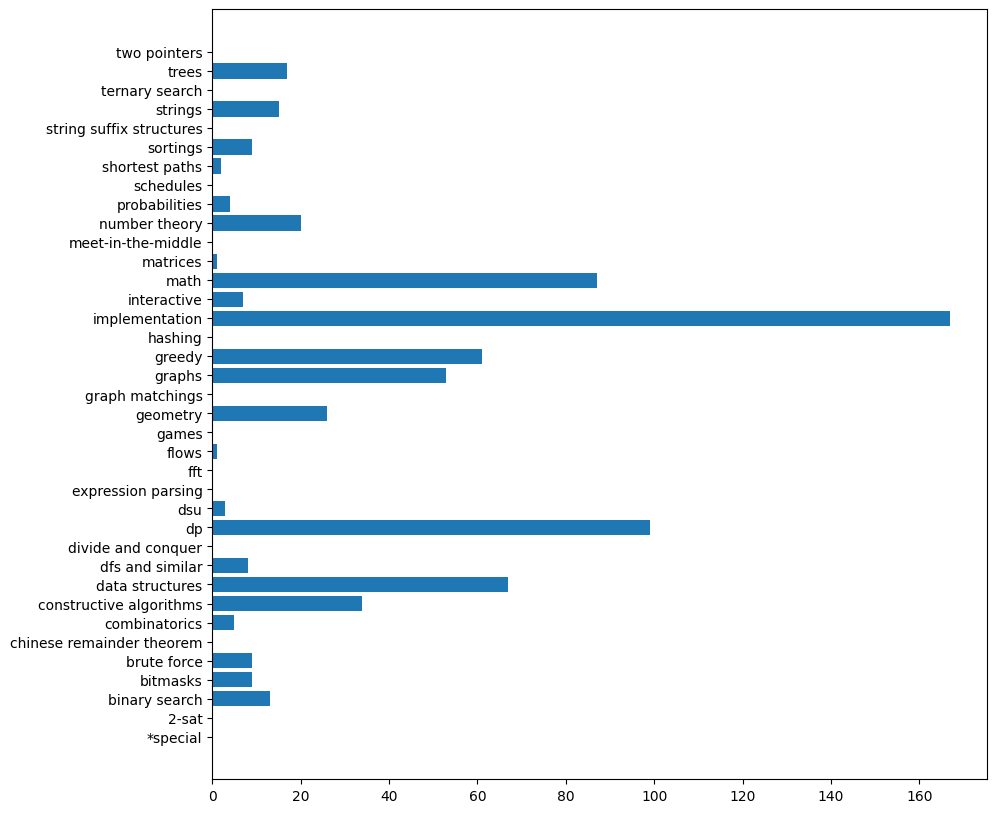

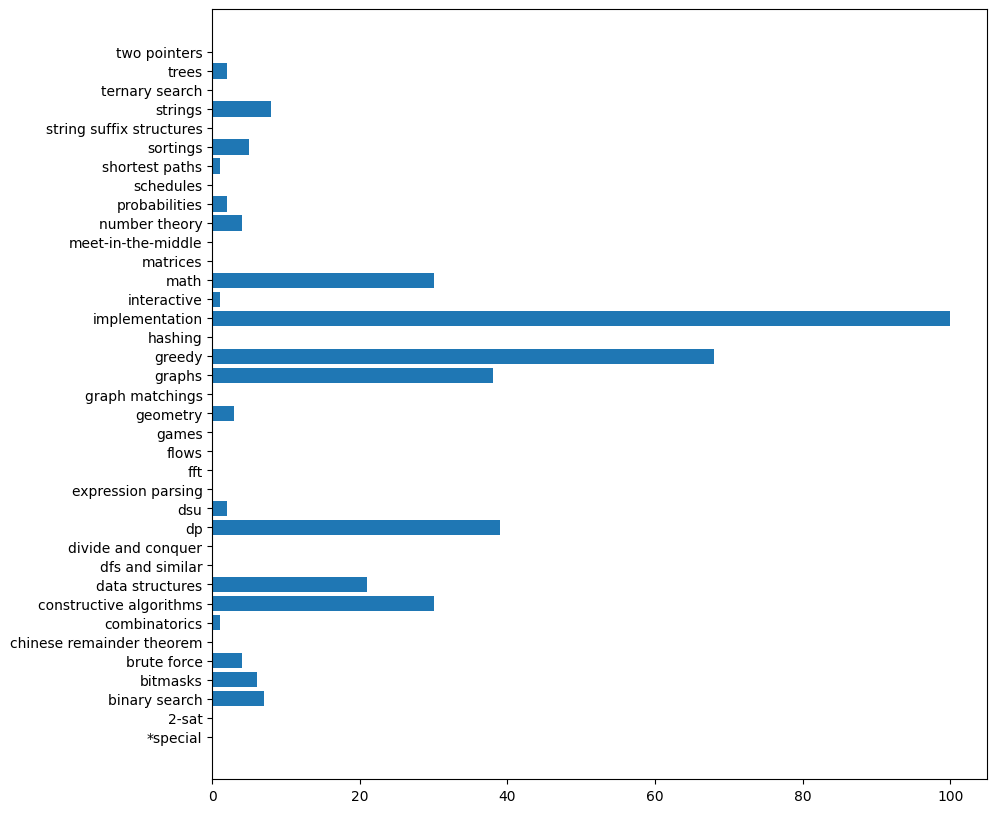

In [919]:
N = 2
for n in range(1,N):
  wrong = 0
  right = 0
  right_type_count = [0] * NUM_CLASSIFIERS
  wrong_type_count = [0] * NUM_CLASSIFIERS
  for index in problem_sum.items():
    w, r, right_type_count, wrong_type_count= n_tag(problem_sum[index[0]],problem_check[index[0]],n,right_type_count,wrong_type_count)
    wrong+=w
    right+=r
  print(n,'tags and number of wrong and right prediction:',wrong,right)
  print(n,'tags result:',right/(wrong + right) * 100)
  visualize(right_type_count)
  visualize(wrong_type_count)

# Apriori Algorithm

In [920]:
def label_transform(predicted_set):
    cnt = 0
    result = [0] * len(predicted_set)
    for i in range(len(predicted_set)):
        t_set = [int(predicted_set[i][index] >= 0.4) for index in range(len(predicted_set[i]))]
        result[i] = list(mlb.inverse_transform(np.reshape(t_set, (-1, NUM_CLASSIFIERS)))[0])
        if (result[i] == []):
            #top = np.argmax(predicted_set[i])
            #t_set = [0] * NUM_CLASSIFIERS
            #t_set[top] = 1
            #result[i] = list(mlb.inverse_transform(np.reshape(t_set, (-1, NUM_CLASSIFIERS)))[0])
            cnt+=1
    return result
apriori_set = label_transform(y_pred)

In [921]:
# Custom Accuracy
problem_items = defaultdict()
problem_count = defaultdict()
problem_check = defaultdict()
problem_sum = defaultdict()
for index in range(len(apriori_set)):
  pos = test_set['problem_name'][index]
  problem_items[pos] = []
  problem_check[pos] = np.zeros(y_test[0].shape).astype(int)
  problem_sum[pos] = np.zeros(y_pred[0].shape).astype(float)
  problem_count[pos] = 0
for index in range(len(apriori_set)):
  pos = test_set['problem_name'][index]
  if apriori_set[index] != []:
    problem_items[pos].append(apriori_set[index])
  problem_sum[pos] = np.sum([problem_sum[pos],y_pred[index]], axis = 0)
  problem_check[pos] = y_test[index]
  problem_count[pos] +=1
for value in problem_sum:
  problem_sum[value]= np.divide(problem_sum[value],problem_count[value])

In [922]:
def apriori(data, sp_T = 0.5):
    init = []
    for i in data:
        for q in i:
            if(q not in init):
                init.append(q)
    init = sorted(init)
    s = int(len(init) * sp_T)
    c = Counter()
    for i in init:
        for d in data:
            if(i in d):
                c[i]+=1
    l = Counter()
    for i in c:
        if(c[i] >= s):
            l[frozenset([i])]+=c[i]
    pl = l
    pos = 1
    for count in range (2,1000):
        nc = set()
        temp = list(l)
        for i in range(0,len(temp)):
            for j in range(i+1,len(temp)):
                t = temp[i].union(temp[j])
                if(len(t) == count):
                    nc.add(temp[i].union(temp[j]))
        nc = list(nc)
        c = Counter()
        for i in nc:
            c[i] = 0
            for q in data:
                temp = set(q)
                if(i.issubset(temp)):
                    c[i]+=1
        l = Counter()
        for i in c:
            if(c[i] >= s):
                l[i]+=c[i]
        if(len(l) == 0):
            break
        pl = l
        pos = count
    return pl
def IoU(keys,values):
    tags = dict()
    for index in range(len(keys)):
        tags[str(index)] = {'tags' : keys[index], 'value' : values[index]}
    maxValue = max(tags.items(), key = lambda x: x[1]['value'])
    res = list()
    for key, value in tags.items():
        if (value['value'] == maxValue[1]['value']):
            res.append(value['tags'])
    #if (len(res[0]) == 1):
    temp = set(res[0])
    for index in range(1,len(res)):
        temp = temp.union(set(res[index]))
    #else:
    #temp = set(res[0])
    #for index in range(1,len(res)):
    #    temp = temp.intersection(set(res[index]))
    return list(temp)

In [923]:
na_cnt = 0
for prob_name in problem_items:
        result = dict(apriori(problem_items[prob_name]))
        if (result != {}):
            keys = [list(k) for k in list(result.keys())]
            values = [v for v in list(result.values())]
            t = list()
            t.append(IoU(keys,values))
            if (t == [[]]):
                indexed = list(enumerate(problem_sum[prob_name]))
                top = np.argmax(problem_sum[prob_name])
                problem_items[prob_name] =  np.zeros(shape=(NUM_CLASSIFIERS), dtype = np.int64)
                problem_items[prob_name][top] = 1
            else:
                t = mlb.transform(t)             
                problem_items[prob_name] = t[0]
        else:
            na_cnt +=1
            indexed = list(enumerate(problem_sum[prob_name]))
            top = np.argmax(problem_sum[prob_name])
            problem_items[prob_name] =  np.zeros(shape=(NUM_CLASSIFIERS), dtype = np.int64)
            problem_items[prob_name][top] = 1
print(na_cnt)

111


In [924]:
from sklearn.metrics import f1_score, hamming_loss

predict_set = list()
check_set = list()
print(len(problem_items.items()))
for prob_name in problem_items:
    predict_set.append(problem_items[prob_name])
    check_set.append(problem_check[prob_name])   
    #print('predict')
    #print(problem_items[prob_name])
    #print('check')
    #print(problem_check[prob_name])
    if (mlb.inverse_transform(np.reshape(problem_items[prob_name],(-1,NUM_CLASSIFIERS)))[0] == ()):
        print(prob_name)
    print(mlb.inverse_transform(np.reshape(problem_items[prob_name],(-1,NUM_CLASSIFIERS)))[0],mlb.inverse_transform(np.reshape(problem_check[prob_name],(-1,NUM_CLASSIFIERS)))[0])
print(f1_score(predict_set, check_set, average = 'micro'))
print(f1_score(predict_set, check_set, average = 'macro'))
print(hamming_loss(predict_set, check_set))

1089
('constructive algorithms', 'greedy', 'implementation', 'strings') ('strings',)
('data structures', 'dfs and similar', 'dp', 'graphs', 'trees') ('dfs and similar', 'graphs', 'trees')
('dp', 'greedy', 'implementation') ('greedy',)
('brute force', 'constructive algorithms', 'greedy', 'implementation', 'sortings') ('games', 'greedy', 'sortings')
('constructive algorithms',) ('combinatorics', 'dfs and similar', 'dsu', 'graphs', 'greedy')
('dp', 'greedy', 'implementation', 'two pointers') ('binary search', 'combinatorics', 'data structures', 'two pointers')
('binary search', 'data structures', 'dp') ('binary search', 'dp')
('greedy',) ('constructive algorithms',)
('math',) ('binary search', 'math')
('greedy', 'implementation', 'strings') ('binary search', 'bitmasks', 'brute force', 'greedy', 'implementation', 'strings')
('binary search', 'implementation') ('binary search', 'constructive algorithms', 'geometry', 'interactive')
('bitmasks', 'dp') ('bitmasks', 'brute force', 'dp', 'implem